In [ ]:
# ===========================
# Investigated the homogeneous binary nucleation of atmospherically-relevant molecules
# =========================== 

# 📊 Generate Plot: 
#     Output growth (cluster size vs. time) with color: sphericity / mole-fraction 
# ---------------------------
# Table of Contents
# 1️⃣ Plot growth (cluster size vs. time) with color: mole-fraction 
# 2️⃣ Plot growth (cluster size vs. time) with color: sphericity
# ----------------------------

Starting to read parquet files...
Merging dataframes...
Computing merged dataframe...
Data read and merged in 2.33 seconds.
Computing size-time statistics for main plot...
Size-time statistics for main plot computed in 0.59 seconds.
Computing size-time statistics for inset plot...
Size-time statistics for inset plot computed in 0.11 seconds.
Starting to plot the data...
Plotting completed in 0.14 seconds.


/tmp/ipykernel_3929/2717818884.py:533: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


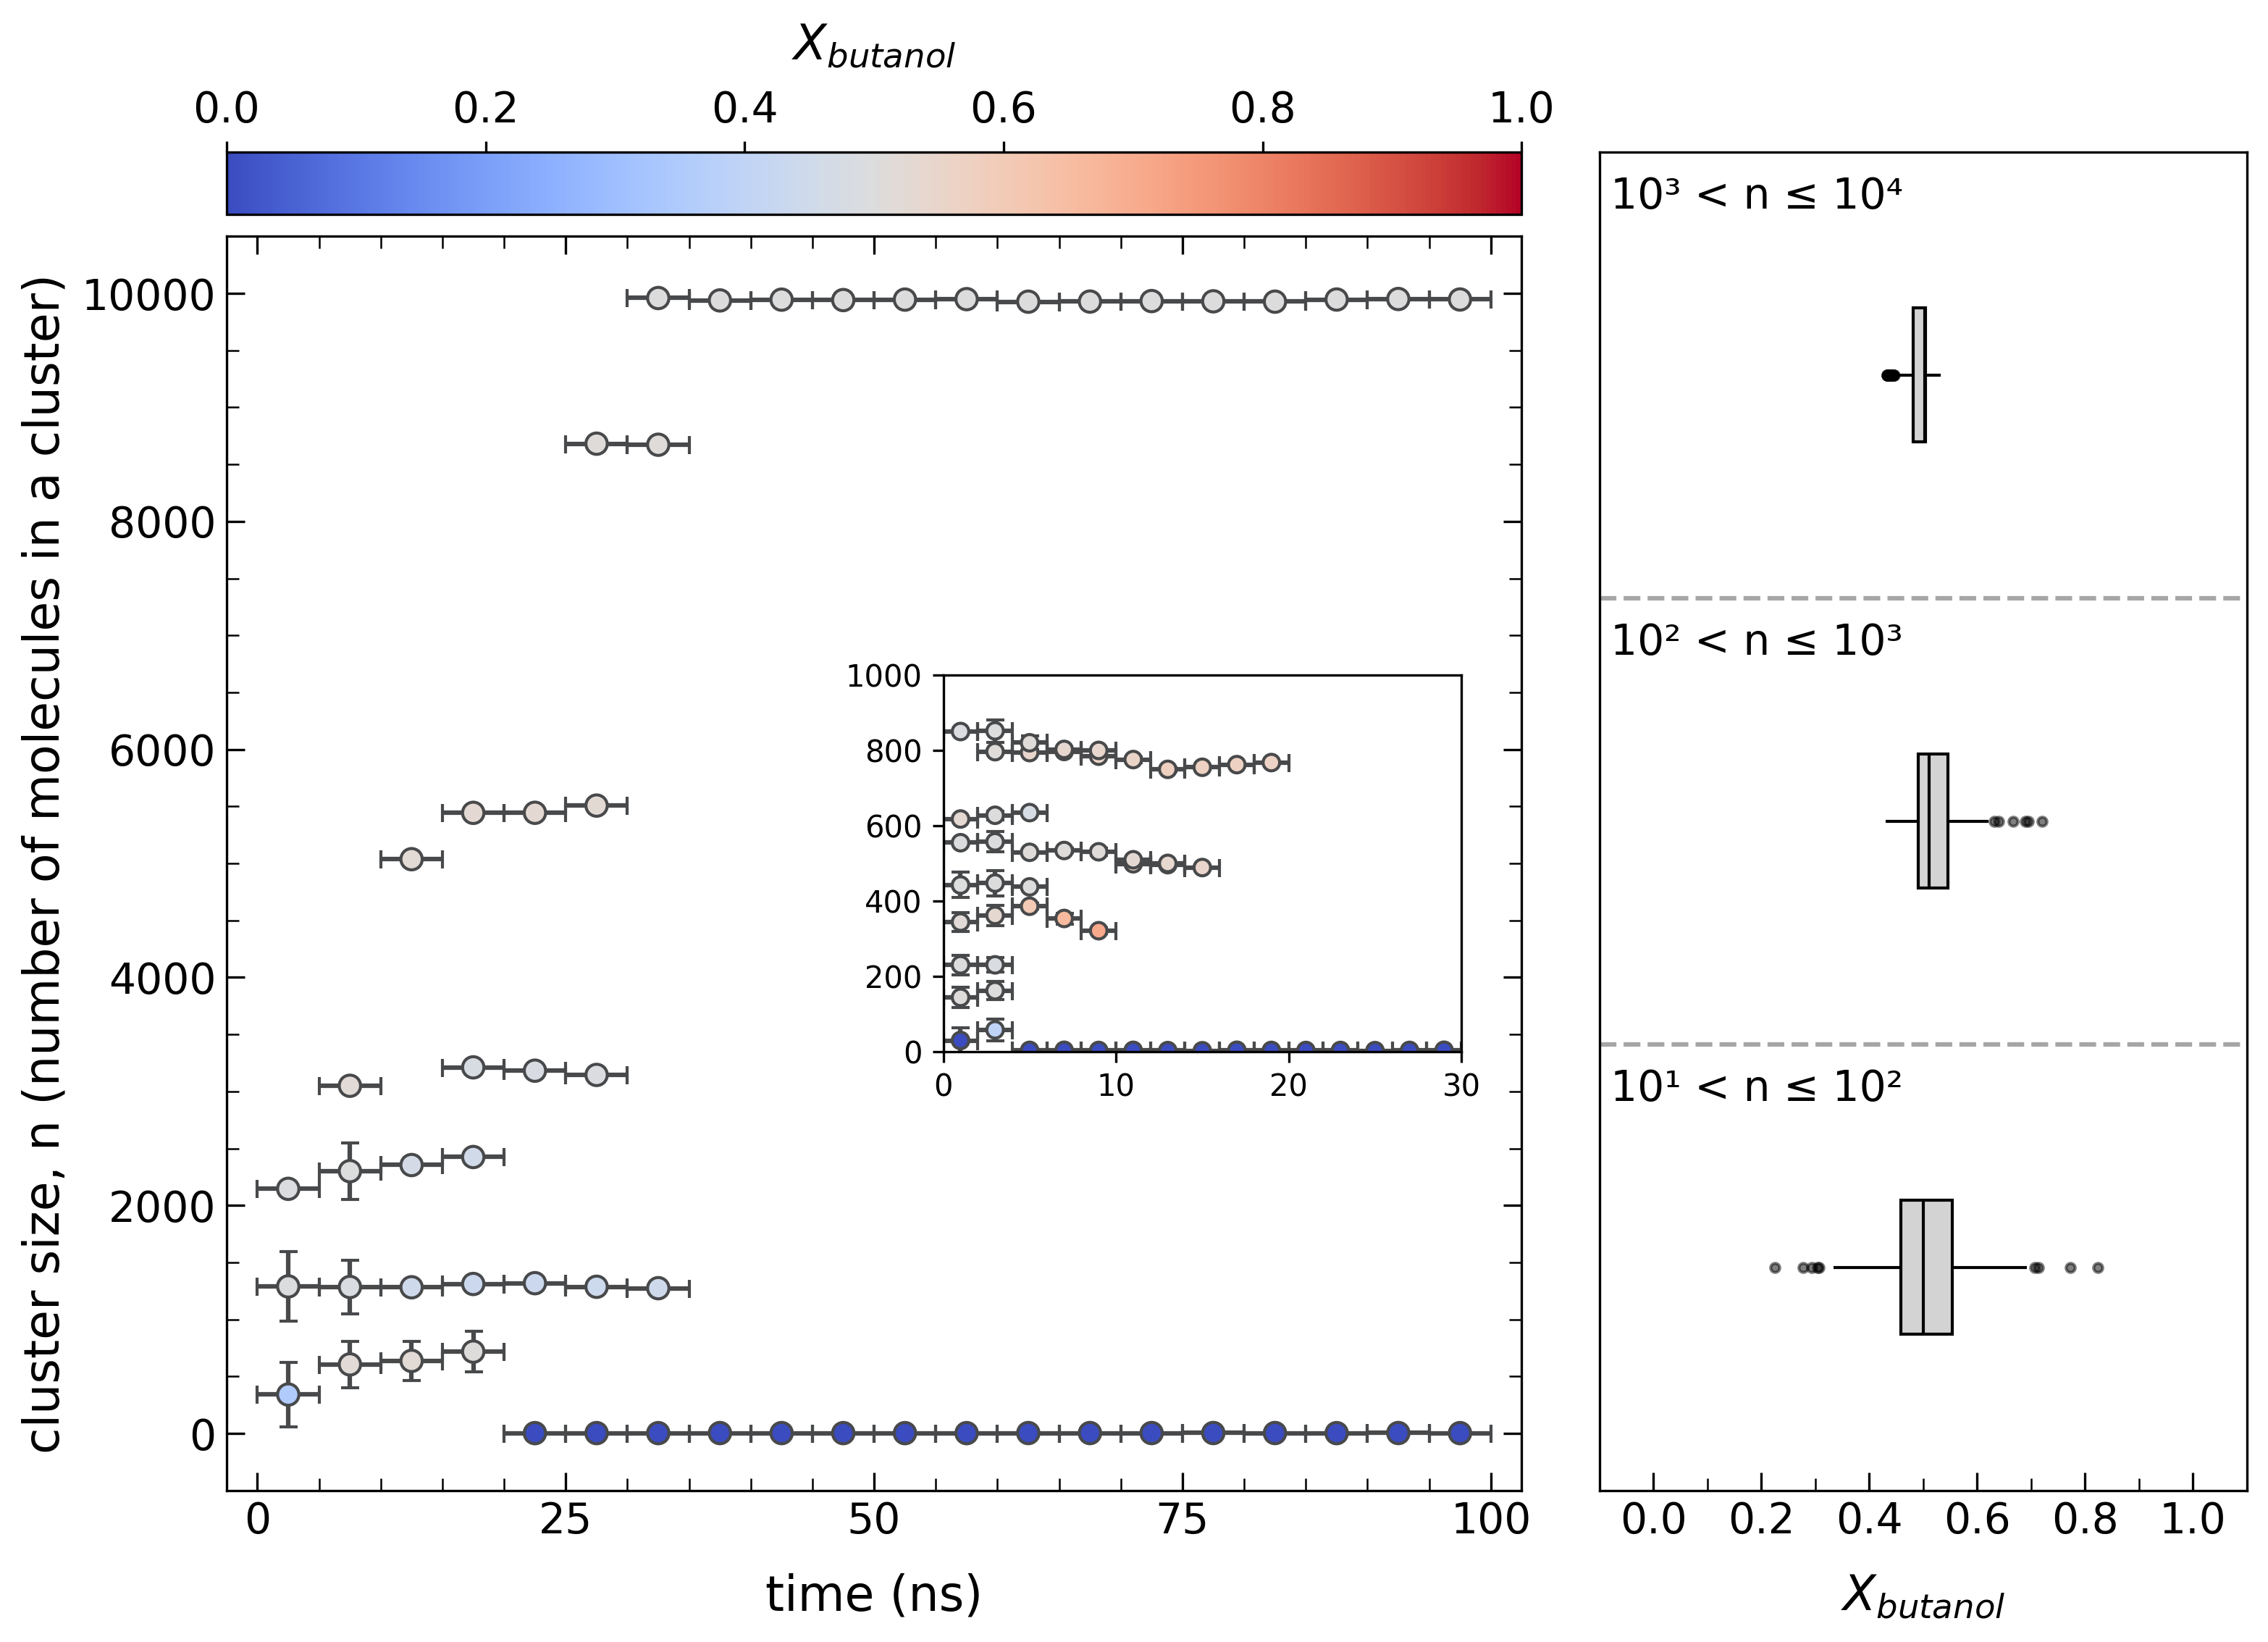

Combined plot saved to ./fig/fig_mole_fraction_combined_BUT_MET.png


In [1]:
# ===============================
# 1️⃣ Plot growth (cluster size vs. time) with color: mole-fraction 
# ===============================
# 📆 Date created: October 12, 2024 
# 📆 Date updated: October 13, 2024 

import os
import time
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mole_fraction_boxplot_seaborn_swapped(
    df,
    ax,
    size_categories=None,
    x_settings=None
):
    """
    Plots boxplots of mole_fraction_molecule1 for specified cluster size categories using Seaborn.
    Swaps x and y axes, arranges y-axis categories in descending order with equal spacing,
    hides y-axis ticks, and annotates the categories in the upper left of each boxplot.
    """
    # Define default size categories if not provided
    if size_categories is None:
        size_categories = [
            (10**3, 10**4, "10³ < Size ≤ 10⁴"),
            (10**2, 10**3, "10² < Size ≤ 10³"),
            (10**1, 10**2, "10¹ < Size ≤ 10²")
        ]
    
    # Define default x-axis settings if not provided
    x_settings = x_settings or {
        'x_min': -0.1,
        'x_max': 1.1,
        'xticks': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'xlabel': "$X_{butanol}$",
        'labelpad': 15,
        'label_size': 16,
        'ticks_size': 14
    }
    
    # Initialize a list to hold data for each category
    boxplot_data = []
    category_labels = []
    
    for lower, upper, label in size_categories:
        # Filter data within the current size range
        subset = df[(df['size'] > lower) & (df['size'] <= upper)]
        boxplot_data.append(subset['mole_fraction_molecule1'].dropna())
        category_labels.append(label)
    
    # Reverse the order of categories
    category_labels = category_labels[::-1]
    boxplot_data = boxplot_data[::-1]
    
    # Create a DataFrame suitable for Seaborn
    boxplot_df = pd.DataFrame({
        'Cluster Size Category': np.repeat(category_labels, [len(data) for data in boxplot_data]),
        'Mole Fraction of Molecule1': pd.concat(boxplot_data, ignore_index=True)
    })
    
    # Define the colors
    box_color = 'lightgray'
    edge_color = 'black'
    outlier_color = 'black'
    
    # Create the boxplot using Seaborn with equal y-axis spacing
    sns.boxplot(
        y='Cluster Size Category',  # Cluster size on the y-axis
        x='Mole Fraction of Molecule1',  # Mole fraction on the x-axis
        data=boxplot_df,
        order=category_labels,  # Ensure consistent spacing and descending order
        boxprops=dict(edgecolor=edge_color, facecolor=box_color),
        width=0.3,
        capprops=dict(linewidth=0),
        medianprops=dict(color='black'),
        whiskerprops=dict(color=edge_color),
        flierprops=dict(
            marker='o',
            markerfacecolor=outlier_color,
            markeredgecolor=outlier_color,
            markersize=3,
            linestyle='none',
            alpha=0.5
        ),
        ax=ax  # Specify the axes
    )
    
    # Set y-axis limits to ensure equal spacing
    y_positions = np.arange(len(category_labels))  # Equal spacing for categories
    ax.set_ylim(-0.5, len(category_labels) - 0.5)
    ax.set_yticks([])  # Hide y-axis ticks and labels
    
    # Apply x-axis settings
    ax.set_xlim(x_settings['x_min'], x_settings['x_max'])
    ax.set_xticks(x_settings['xticks'])
    ax.set_xlabel(x_settings['xlabel'], fontsize=x_settings['label_size'], labelpad=x_settings['labelpad'])
    ax.tick_params(axis='x', labelsize=x_settings['ticks_size'],direction='in',length=6)
    ax.set_ylabel('')

    
    # Annotate the categories in the upper left of each boxplot
    for i, label in enumerate(category_labels):
        ax.text(
            x_settings['x_min'] + 0.02,  # Slightly offset from the x-axis min
            i + 0.4,  # Position corresponding to the y-category
            label,
            ha='left', va='center', fontsize=x_settings['ticks_size']
        )
    
    # Set minor locator for x-axis
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Customize minor tick appearance on x-axis
    ax.tick_params(axis='x', which='minor', direction='in', length=4, color='black')
    
    # Add horizontal dashed lines as separators between boxplots
    separator_positions = np.arange(len(category_labels) - 1) + 0.5
    for pos in separator_positions:
        ax.hlines(y=pos, xmin=x_settings['x_min'], xmax=x_settings['x_max'], color='gray', linestyle='--', alpha=0.7)
    
    # Add gridlines only on the x-axis
    #ax.grid(True, axis='x', linestyle="--", alpha=0.7)

def read_and_merge_data():
    """
    Reads the parquet files and merges them into a single dataframe.
    """
    start_time = time.time()
    print("Starting to read parquet files...")
    
    # Read parquet files using Dask
    df1 = dd.read_parquet('nuc_fort-to-panda_combined.parquet')
    df2 = dd.read_parquet('nuc_analysis_mole-fraction_combined.parquet')
    
    # Rename 'frame' to 'frame_number' in df2 for consistency
    df2 = df2.rename(columns={'frame': 'frame_number'})
    
    print("Merging dataframes...")
    # Merge the two dataframes
    merged_df = dd.merge(
        df1,
        df2[['frame_number', 'size', 'nucleus_id', 'mole_fraction_molecule1']],
        on=['frame_number', 'size', 'nucleus_id'],
        how='left'
    )
    
    # Fill missing values
    merged_df['mole_fraction_molecule1'] = merged_df['mole_fraction_molecule1'].fillna(-1)
    merged_df['nucleus_id'] = merged_df['nucleus_id'].fillna(0)
    
    # Convert frame_number to time in nanoseconds
    merged_df['time_ns'] = merged_df['frame_number'] * 0.5
    
    # Convert Dask dataframe to Pandas dataframe for processing
    print("Computing merged dataframe...")
    merged_df = merged_df.compute()
    
    end_time = time.time()
    print(f"Data read and merged in {end_time - start_time:.2f} seconds.")
    
    return merged_df

def compute_size_time_stats(merged_df, size_bin_interval, time_bin_interval):
    """
    Computes the average and standard deviation of 'size' and 'mole_fraction_molecule1' 
    within specified size and time intervals for the main plot.
    """
    start_time = time.time()
    print("Computing size-time statistics for main plot...")
    
    # Define size bins
    size_min = merged_df['size'].min()
    size_max = merged_df['size'].max()
    size_bins = np.arange(size_min, size_max + size_bin_interval, size_bin_interval)
    
    # Define time bins
    time_min = merged_df['time_ns'].min()
    time_max = merged_df['time_ns'].max()
    time_bins = np.arange(time_min, time_max + time_bin_interval, time_bin_interval)
    
    # Bin the data
    merged_df['size_bin'] = pd.cut(merged_df['size'], bins=size_bins, include_lowest=True, right=False)
    merged_df['time_bin'] = pd.cut(merged_df['time_ns'], bins=time_bins, include_lowest=True, right=False)
    
    # Group by both size_bin and time_bin and compute mean and std of 'size' and mean of 'mole_fraction_molecule1'
    grouped = merged_df.groupby(['time_bin', 'size_bin'], observed=False).agg({
        'size': ['mean', 'std'],
        'mole_fraction_molecule1': ['mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    grouped.columns = ['time_bin', 'size_bin', 'size_mean', 'size_std', 'mole_fraction_molecule1_mean']
    
    # Compute midpoints of time bins for plotting
    grouped['time_midpoint'] = grouped['time_bin'].apply(lambda x: x.mid).astype(float)
    # Compute midpoints of size bins for labeling if needed
    grouped['size_midpoint'] = grouped['size_bin'].apply(lambda x: x.mid).astype(float)
    
    # Ensure 'size_mean' and 'size_std' are numeric
    grouped['size_mean'] = pd.to_numeric(grouped['size_mean'], errors='coerce')
    grouped['size_std'] = pd.to_numeric(grouped['size_std'], errors='coerce')
    
    end_time = time.time()
    print(f"Size-time statistics for main plot computed in {end_time - start_time:.2f} seconds.")
    
    return grouped

def compute_size_time_stats_inset(merged_df, size_bin_interval_inset, time_bin_interval_inset, x_inset_range, y_inset_range):
    """
    Computes the size-time statistics specifically for the inset plot using different bin intervals.
    """
    start_time = time.time()
    print("Computing size-time statistics for inset plot...")
    
    # Filter data within the inset ranges
    inset_df = merged_df[
        (merged_df['time_ns'] >= x_inset_range[0]) &
        (merged_df['time_ns'] <= x_inset_range[1]) &
        (merged_df['size'] >= y_inset_range[0]) &
        (merged_df['size'] <= y_inset_range[1])
    ].copy()
    
    # Define size bins for inset
    size_min = y_inset_range[0]
    size_max = y_inset_range[1]
    size_bins = np.arange(size_min, size_max + size_bin_interval_inset, size_bin_interval_inset)
    
    # Define time bins for inset
    time_min = x_inset_range[0]
    time_max = x_inset_range[1]
    time_bins = np.arange(time_min, time_max + time_bin_interval_inset, time_bin_interval_inset)
    
    # Bin the data
    inset_df['size_bin'] = pd.cut(inset_df['size'], bins=size_bins, include_lowest=True, right=False)
    inset_df['time_bin'] = pd.cut(inset_df['time_ns'], bins=time_bins, include_lowest=True, right=False)
    
    # Group and compute statistics
    grouped_inset = inset_df.groupby(['time_bin', 'size_bin'], observed=False).agg({
        'size': ['mean', 'std'],
        'mole_fraction_molecule1': ['mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    grouped_inset.columns = ['time_bin', 'size_bin', 'size_mean', 'size_std', 'mole_fraction_molecule1_mean']
    
    # Compute midpoints
    grouped_inset['time_midpoint'] = grouped_inset['time_bin'].apply(lambda x: x.mid).astype(float)
    grouped_inset['size_midpoint'] = grouped_inset['size_bin'].apply(lambda x: x.mid).astype(float)
    
    # Ensure numeric types
    grouped_inset['size_mean'] = pd.to_numeric(grouped_inset['size_mean'], errors='coerce')
    grouped_inset['size_std'] = pd.to_numeric(grouped_inset['size_std'], errors='coerce')
    
    end_time = time.time()
    print(f"Size-time statistics for inset plot computed in {end_time - start_time:.2f} seconds.")
    
    return grouped_inset

def plot_size_time_stats(
    grouped_df, 
    grouped_inset_df, 
    ax,
    fig,
    size_bin_interval, 
    time_bin_interval, 
    size_bin_interval_inset,
    time_bin_interval_inset,
    molecule1, 
    molecule2, 
    x_settings, 
    y_settings, 
    x_inset_range, 
    y_inset_range,
    point_edge_color, 
    error_bar_color, 
    xtick_size, 
    ytick_size, 
    xlabel_size, 
    ylabel_size, 
    gridline_color, 
    show_gridlines
):
    """
    Plots the average size over time with error bars representing standard deviations.
    Uses a 'coolwarm' color palette to represent the mole_fraction_molecule1_mean as a color bar.
    Adds an inset plot in the lower right corner zooming into a specific region.
    Positions the color bar at the top of the plot area.
    """
    start_time = time.time()
    print("Starting to plot the data...")
    
    # Fixed x-error based on main plot bin interval
    xerr_fixed = time_bin_interval / 2
    
    # Normalize the mole_fraction_molecule1_mean values between 0 and 1
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Get the coolwarm colormap
    cmap = plt.cm.coolwarm
    
    # Plot main data
    for size_bin in grouped_df['size_bin'].unique():
        bin_df = grouped_df[grouped_df['size_bin'] == size_bin].copy()
        bin_df['time_midpoint'] = pd.to_numeric(bin_df['time_midpoint'], errors='coerce')
        bin_df['size_mean'] = pd.to_numeric(bin_df['size_mean'], errors='coerce')
        colors = cmap(norm(bin_df['mole_fraction_molecule1_mean']))
    
        # Error bars
        ax.errorbar(
            bin_df['time_midpoint'],
            bin_df['size_mean'],
            xerr=xerr_fixed,
            yerr=bin_df['size_std'],
            fmt='none',
            ecolor=error_bar_color,
            capsize=3,
            zorder=1
        )
    
        # Scatter plot
        ax.scatter(
            bin_df['time_midpoint'],
            bin_df['size_mean'],
            color=colors,
            edgecolor=point_edge_color,
            s=50,
            zorder=2
        )
    
    # Axis settings for main plot
    ax.set_xlim(x_settings['x_min'], x_settings['x_max'])
    ax.set_xticks(x_settings['xticks'])
    ax.set_xlabel('time (ns)', labelpad=x_settings.get('labelpad', 5), fontsize=xlabel_size)
    ax.tick_params(axis='x', labelsize=xtick_size)
    
    ax.set_ylim(y_settings['y_min'], y_settings['y_max'])
    ax.set_yticks(y_settings['yticks'])
    ax.set_ylabel('cluster size, n (number of molecules in a cluster)', fontsize=ylabel_size)
    ax.tick_params(axis='y', labelsize=ytick_size)
    
    # Grid and ticks
    if show_gridlines:
        ax.grid(True, color=gridline_color)
    else:
        ax.grid(False)
        ax.tick_params(axis='both', which='major', direction='in', length=6)
        ax.tick_params(axis='both', which='minor', direction='in', length=4)
        ax.tick_params(top=True, bottom=True, left=True, right=True)
        ax.tick_params(which='minor', top=True, bottom=True, left=True, right=True)
    
    ax.minorticks_on()
    
    # Create a colorbar above the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='5%', pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('$X_{butanol}$', labelpad=10, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    
    # Inset axes
    ax_inset = inset_axes(ax, width="40%", height="30%", loc="center right", borderpad=2)
    ax_inset.set_xlim(x_inset_range[0], x_inset_range[1])
    ax_inset.set_ylim(y_inset_range[0], y_inset_range[1])
    
    # Fixed x-error based on inset bin interval
    xerr_fixed_inset = time_bin_interval_inset / 2
    
    # Plot inset data
    for size_bin in grouped_inset_df['size_bin'].unique():
        bin_df_inset = grouped_inset_df[grouped_inset_df['size_bin'] == size_bin].copy()
        bin_df_inset['time_midpoint'] = pd.to_numeric(bin_df_inset['time_midpoint'], errors='coerce')
        bin_df_inset['size_mean'] = pd.to_numeric(bin_df_inset['size_mean'], errors='coerce')
        colors_inset = cmap(norm(bin_df_inset['mole_fraction_molecule1_mean']))
    
        # Error bars in inset
        ax_inset.errorbar(
            bin_df_inset['time_midpoint'],
            bin_df_inset['size_mean'],
            xerr=xerr_fixed_inset,
            yerr=bin_df_inset['size_std'],
            fmt='none',
            ecolor=error_bar_color,
            capsize=3,
            zorder=1
        )
    
        # Scatter plot in inset
        ax_inset.scatter(
            bin_df_inset['time_midpoint'],
            bin_df_inset['size_mean'],
            color=colors_inset,
            edgecolor=point_edge_color,
            s=30,
            zorder=2
        )
    
    # Inset adjustments
    ax_inset.tick_params(axis='both', which='both', labelsize=10)
    ax_inset.set_xlabel('')
    ax_inset.set_ylabel('')
    
    end_time = time.time()
    print(f"Plotting completed in {end_time - start_time:.2f} seconds.")

def main():
    # Read data for boxplot
    df_boxplot = pd.read_parquet('nuc_analysis_mole-fraction_combined.parquet')

    # Read and merge data for scatter plot
    merged_df = read_and_merge_data()

    # Compute statistics for the scatter plot
    # Define intervals for main plot
    size_bin_interval = 1000  # Adjust as needed
    time_bin_interval = 5     # Adjust as needed

    # Define intervals for inset plot
    size_bin_interval_inset = 100  # Adjust as needed
    time_bin_interval_inset = 2  # Adjust as needed

    # X and Y axis settings for main plot
    x_settings_left = {'x_min': -2.5, 'x_max': 102.5, 'xticks': [0, 25, 50, 75, 100], 'labelpad': 10}
    y_settings_left = {'y_min': -500, 'y_max': 10500, 'yticks': [0, 2000, 4000, 6000, 8000, 10000]}

    # Inset plot ranges
    x_inset_range = (0, 30)
    y_inset_range = (0, 1000)

    # Define color settings
    point_edge_color = '#48494B'
    error_bar_color = '#48494B'

    # Tick and label size settings
    xtick_size = 14
    ytick_size = 14
    xlabel_size = 16
    ylabel_size = 16

    # Gridline color
    gridline_color = 'grey'

    # Show gridlines or not
    show_gridlines = False

    # Compute size-time statistics for main plot
    grouped_df = compute_size_time_stats(merged_df, size_bin_interval, time_bin_interval)

    # Compute size-time statistics for inset plot
    grouped_inset_df = compute_size_time_stats_inset(
        merged_df, 
        size_bin_interval_inset, 
        time_bin_interval_inset, 
        x_inset_range, 
        y_inset_range
    )

    # Create figure with custom GridSpec layout
    fig = plt.figure(figsize=(12, 8), dpi=300)  # Adjust overall figure size here
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0.08)  # Adjust width ratios and spacing

    # Create subplots with custom sizes
    ax_left = fig.add_subplot(gs[0])  # Left subplot (scatter plot)
    ax_right = fig.add_subplot(gs[1])  # Right subplot (boxplot)

    # Now you can adjust the width_ratios to control the relative widths of the subplots.
    # For example, width_ratios=[3, 1] makes the left subplot three times wider than the right one.
    # Similarly, you can adjust the height of the subplots by changing the figure size or using height_ratios.

    # Plot scatter plot on the left
    molecule1 = "BUT"
    molecule2 = "MET"
    plot_size_time_stats(
        grouped_df, 
        grouped_inset_df, 
        ax=ax_left,
        fig=fig,
        size_bin_interval=size_bin_interval, 
        time_bin_interval=time_bin_interval, 
        size_bin_interval_inset=size_bin_interval_inset,
        time_bin_interval_inset=time_bin_interval_inset,
        molecule1=molecule1, 
        molecule2=molecule2, 
        x_settings=x_settings_left, 
        y_settings=y_settings_left, 
        x_inset_range=x_inset_range, 
        y_inset_range=y_inset_range,
        point_edge_color=point_edge_color, 
        error_bar_color=error_bar_color, 
        xtick_size=xtick_size, 
        ytick_size=ytick_size, 
        xlabel_size=xlabel_size, 
        ylabel_size=ylabel_size, 
        gridline_color=gridline_color, 
        show_gridlines=show_gridlines
    )

    # Plot boxplot on the right
    size_categories = [
        (10**3, 10**4, "10³ < n ≤ 10⁴"),
        (10**2, 10**3, "10² < n ≤ 10³"),
        (10**1, 10**2, "10¹ < n ≤ 10²")
    ]
    x_settings_right = {
        'x_min': -0.1,
        'x_max': 1.1,
        'xticks': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'xlabel': "$X_{butanol}$",
        'labelpad': 10,
        'label_size': 16,
        'ticks_size': 14
    }
    plot_mole_fraction_boxplot_seaborn_swapped(
        df_boxplot,
        ax=ax_right,
        size_categories=size_categories,
        x_settings=x_settings_right
    )

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save and show the combined plot
    save_path = "./fig/"
    filename = "fig_mole_fraction_combined_BUT_MET.png"
    save_file_path = os.path.join(save_path, filename)
    plt.savefig(save_file_path, dpi=300)
    plt.show()
    print(f"Combined plot saved to {save_file_path}")

if __name__ == "__main__":
    main()


Starting to read parquet files...
Computing dataframe...
Calculating sphericity for clusters...
Sphericity calculated in 34.62 seconds.
Data read and sphericity calculated in 36.73 seconds.
Computing size-time statistics for main plot...
Size-time statistics for main plot computed in 0.60 seconds.
Computing size-time statistics for inset plot...
Size-time statistics for inset plot computed in 0.12 seconds.
Starting to plot the data...
Plotting completed in 0.14 seconds.


/tmp/ipykernel_3929/3916344495.py:572: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


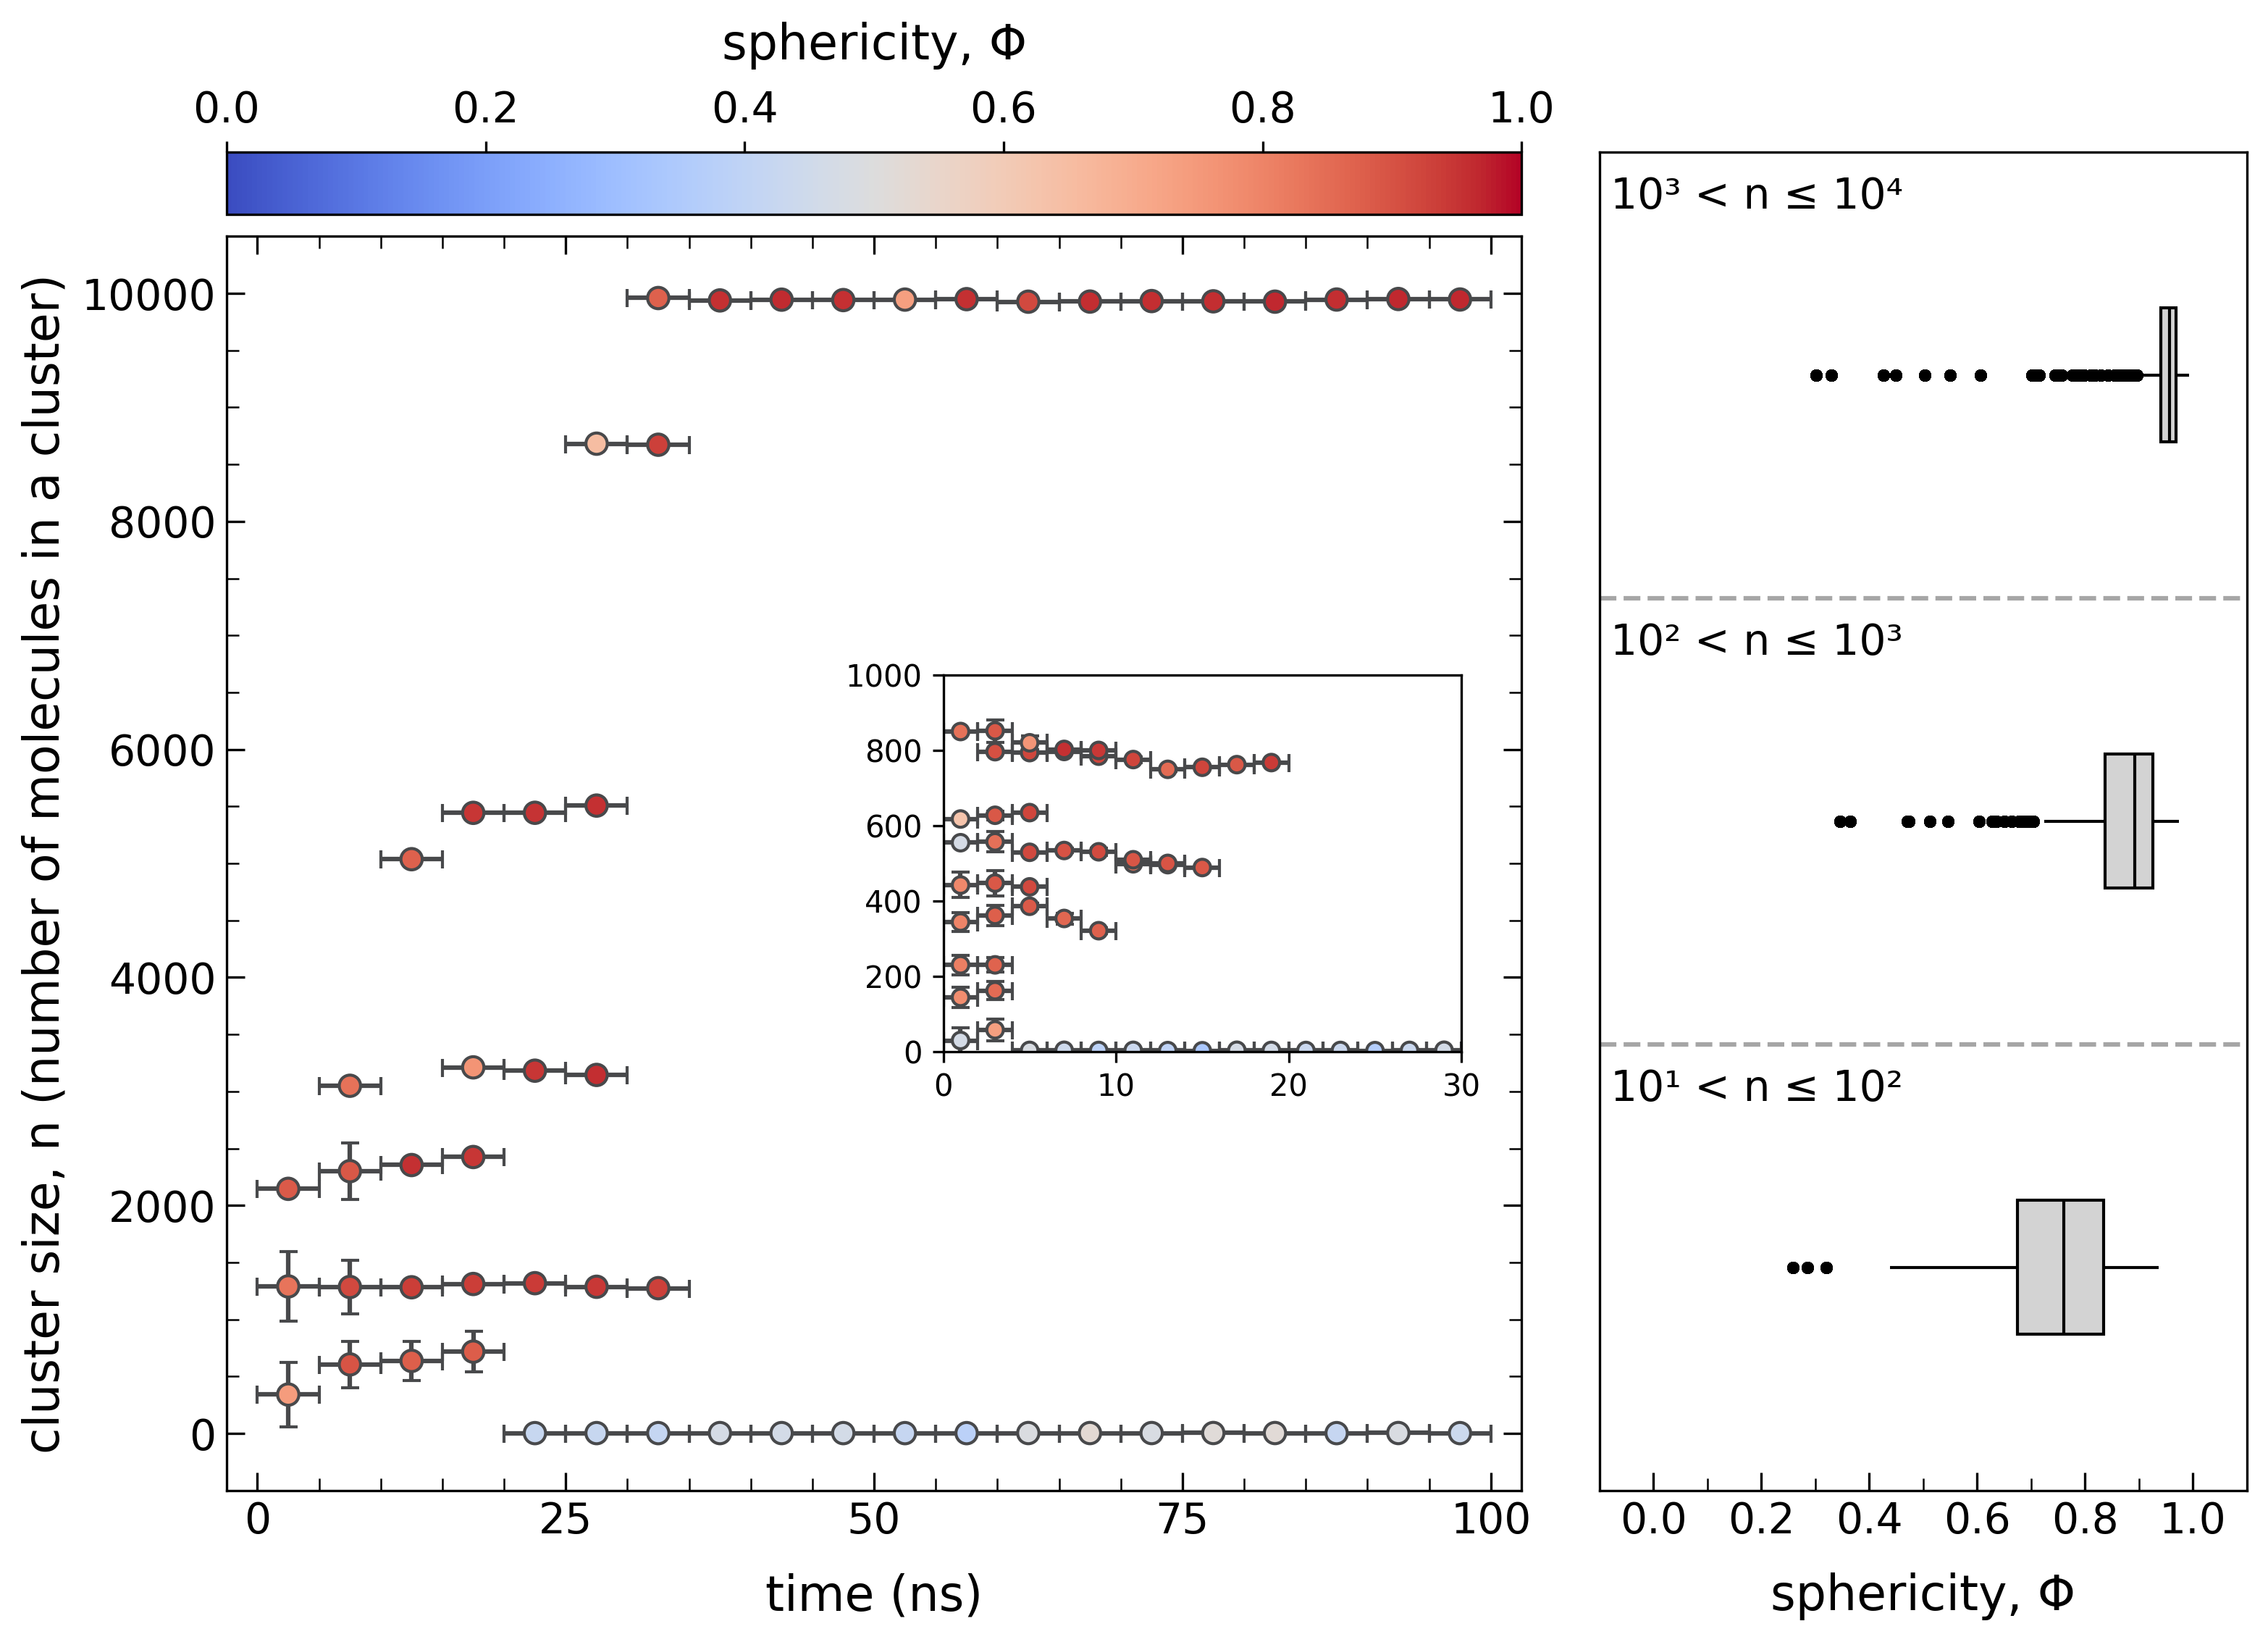

Combined plot saved to ./fig/fig_sphericity_combined_BUT_MET.png


In [2]:
# ===============================
# 2️⃣ Plot growth (cluster size vs. time) with color: sphericity
# ===============================
# 📆 Date created: October 12, 2024 
# 📆 Date updated: October 13, 2024

import os
import time
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

def calculate_sphericity(df):
    """
    Calculates sphericity for each cluster in the dataframe.
    """
    start_time = time.time()
    print("Calculating sphericity for clusters...")

    # Initialize 'sphericity' column
    df['sphericity'] = np.nan

    # Group by 'frame_number' and 'nucleus_id' to identify clusters
    grouped = df.groupby(['frame_number', 'nucleus_id'])

    for (frame, nucleus), group in grouped:
        # If the group has less than 3 atoms, sphericity is undefined (set to NaN)
        if len(group) < 3:
            sphericity = np.nan
        else:
            # Calculate centroid (mean of x, y, z coordinates)
            centroid = group[['x_coord', 'y_coord', 'z_coord']].mean().values

            # Calculate relative coordinates centered at the centroid
            coords = group[['x_coord', 'y_coord', 'z_coord']].values - centroid

            # Compute the moment of inertia tensor
            inertia_tensor = np.zeros((3, 3))
            for coord in coords:
                x, y, z = coord
                inertia_tensor[0, 0] += y**2 + z**2
                inertia_tensor[1, 1] += x**2 + z**2
                inertia_tensor[2, 2] += x**2 + y**2
                inertia_tensor[0, 1] -= x * y
                inertia_tensor[0, 2] -= x * z
                inertia_tensor[1, 2] -= y * z

            inertia_tensor[1, 0] = inertia_tensor[0, 1]
            inertia_tensor[2, 0] = inertia_tensor[0, 2]
            inertia_tensor[2, 1] = inertia_tensor[1, 2]

            # Calculate eigenvalues (principal moments of inertia)
            principal_moments = np.linalg.eigvalsh(inertia_tensor)

            # Avoid division by zero
            if np.sum(principal_moments) != 0:
                # Sphericity formula
                sphericity = 3 * np.min(principal_moments) / np.sum(principal_moments)
            else:
                sphericity = np.nan

        # Assign sphericity to the group
        df.loc[group.index, 'sphericity'] = sphericity

    end_time = time.time()
    print(f"Sphericity calculated in {end_time - start_time:.2f} seconds.")
    return df

def read_and_merge_data():
    """
    Reads the parquet files and calculates sphericity.
    """
    start_time = time.time()
    print("Starting to read parquet files...")
    
    # Read parquet file using Dask
    df1 = dd.read_parquet('nuc_fort-to-panda_combined.parquet')
    
    # Ensure that df1 contains 'x_coord', 'y_coord', 'z_coord'
    
    # Fill missing values
    df1['nucleus_id'] = df1['nucleus_id'].fillna(0)
    
    # Convert frame_number to time in nanoseconds
    df1['time_ns'] = df1['frame_number'] * 0.5
    
    # Convert Dask dataframe to Pandas dataframe for processing
    print("Computing dataframe...")
    df1 = df1.compute()
    
    # Calculate sphericity
    df1 = calculate_sphericity(df1)
    
    end_time = time.time()
    print(f"Data read and sphericity calculated in {end_time - start_time:.2f} seconds.")
    
    return df1

def compute_size_time_stats(merged_df, size_bin_interval, time_bin_interval):
    """
    Computes the average and standard deviation of 'size' and 'sphericity' 
    within specified size and time intervals for the main plot.
    """
    start_time = time.time()
    print("Computing size-time statistics for main plot...")
    
    # Define size bins
    size_min = merged_df['size'].min()
    size_max = merged_df['size'].max()
    size_bins = np.arange(size_min, size_max + size_bin_interval, size_bin_interval)
    
    # Define time bins
    time_min = merged_df['time_ns'].min()
    time_max = merged_df['time_ns'].max()
    time_bins = np.arange(time_min, time_max + time_bin_interval, time_bin_interval)
    
    # Bin the data
    merged_df['size_bin'] = pd.cut(merged_df['size'], bins=size_bins, include_lowest=True, right=False)
    merged_df['time_bin'] = pd.cut(merged_df['time_ns'], bins=time_bins, include_lowest=True, right=False)
    
    # Group by both size_bin and time_bin and compute mean and std of 'size' and mean of 'sphericity'
    grouped = merged_df.groupby(['time_bin', 'size_bin'], observed=False).agg({
        'size': ['mean', 'std'],
        'sphericity': ['mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    grouped.columns = ['time_bin', 'size_bin', 'size_mean', 'size_std', 'sphericity_mean']
    
    # Compute midpoints of time bins for plotting
    grouped['time_midpoint'] = grouped['time_bin'].apply(lambda x: x.mid).astype(float)
    # Compute midpoints of size bins for labeling if needed
    grouped['size_midpoint'] = grouped['size_bin'].apply(lambda x: x.mid).astype(float)
    
    # Ensure 'size_mean' and 'size_std' are numeric
    grouped['size_mean'] = pd.to_numeric(grouped['size_mean'], errors='coerce')
    grouped['size_std'] = pd.to_numeric(grouped['size_std'], errors='coerce')
    
    end_time = time.time()
    print(f"Size-time statistics for main plot computed in {end_time - start_time:.2f} seconds.")
    
    return grouped

def compute_size_time_stats_inset(merged_df, size_bin_interval_inset, time_bin_interval_inset, x_inset_range, y_inset_range):
    """
    Computes the size-time statistics specifically for the inset plot using different bin intervals.
    """
    start_time = time.time()
    print("Computing size-time statistics for inset plot...")
    
    # Filter data within the inset ranges
    inset_df = merged_df[
        (merged_df['time_ns'] >= x_inset_range[0]) &
        (merged_df['time_ns'] <= x_inset_range[1]) &
        (merged_df['size'] >= y_inset_range[0]) &
        (merged_df['size'] <= y_inset_range[1])
    ].copy()
    
    # Define size bins for inset
    size_min = y_inset_range[0]
    size_max = y_inset_range[1]
    size_bins = np.arange(size_min, size_max + size_bin_interval_inset, size_bin_interval_inset)
    
    # Define time bins for inset
    time_min = x_inset_range[0]
    time_max = x_inset_range[1]
    time_bins = np.arange(time_min, time_max + time_bin_interval_inset, time_bin_interval_inset)
    
    # Bin the data
    inset_df['size_bin'] = pd.cut(inset_df['size'], bins=size_bins, include_lowest=True, right=False)
    inset_df['time_bin'] = pd.cut(inset_df['time_ns'], bins=time_bins, include_lowest=True, right=False)
    
    # Group and compute statistics
    grouped_inset = inset_df.groupby(['time_bin', 'size_bin'], observed=False).agg({
        'size': ['mean', 'std'],
        'sphericity': ['mean']
    }).reset_index()
    
    # Flatten MultiIndex columns
    grouped_inset.columns = ['time_bin', 'size_bin', 'size_mean', 'size_std', 'sphericity_mean']
    
    # Compute midpoints
    grouped_inset['time_midpoint'] = grouped_inset['time_bin'].apply(lambda x: x.mid).astype(float)
    grouped_inset['size_midpoint'] = grouped_inset['size_bin'].apply(lambda x: x.mid).astype(float)
    
    # Ensure numeric types
    grouped_inset['size_mean'] = pd.to_numeric(grouped_inset['size_mean'], errors='coerce')
    grouped_inset['size_std'] = pd.to_numeric(grouped_inset['size_std'], errors='coerce')
    
    end_time = time.time()
    print(f"Size-time statistics for inset plot computed in {end_time - start_time:.2f} seconds.")
    
    return grouped_inset

def plot_sphericity_boxplot_seaborn_swapped(
    df,
    ax,
    size_categories=None,
    x_settings=None
):
    """
    Plots boxplots of sphericity for specified cluster size categories using Seaborn.
    Swaps x and y axes, arranges y-axis categories in descending order with equal spacing,
    hides y-axis ticks, and annotates the categories in the upper left of each boxplot.
    """
    # Define default size categories if not provided
    if size_categories is None:
        size_categories = [
            (10**3, 10**4, "10³ < n ≤ 10⁴"),
            (10**2, 10**3, "10² < n ≤ 10³"),
            (10**1, 10**2, "10¹ < n ≤ 10²")
        ]
    
    # Define default x-axis settings if not provided
    x_settings = x_settings or {
        'x_min': -0.1,
        'x_max': 1.1,
        'xticks': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'xlabel': "Sphericity, Φ",
        'labelpad': 15,
        'label_size': 16,
        'ticks_size': 14
    }
    
    # Initialize a list to hold data for each category
    boxplot_data = []
    category_labels = []
    
    for lower, upper, label in size_categories:
        # Filter data within the current size range
        subset = df[(df['size'] > lower) & (df['size'] <= upper)]
        boxplot_data.append(subset['sphericity'].dropna())
        category_labels.append(label)
    
    # Reverse the order of categories
    category_labels = category_labels[::-1]
    boxplot_data = boxplot_data[::-1]
    
    # Create a DataFrame suitable for Seaborn
    boxplot_df = pd.DataFrame({
        'Cluster Size Category': np.repeat(category_labels, [len(data) for data in boxplot_data]),
        'Sphericity': pd.concat(boxplot_data, ignore_index=True)
    })
    
    # Define the colors
    box_color = 'lightgray'
    edge_color = 'black'
    outlier_color = 'black'
    
    # Create the boxplot using Seaborn with equal y-axis spacing
    sns.boxplot(
        y='Cluster Size Category',  # Cluster size on the y-axis
        x='Sphericity',  # Sphericity on the x-axis
        data=boxplot_df,
        order=category_labels,  # Ensure consistent spacing and descending order
        boxprops=dict(edgecolor=edge_color, facecolor=box_color),
        width=0.3,
        capprops=dict(linewidth=0),
        medianprops=dict(color='black'),
        whiskerprops=dict(color=edge_color),
        flierprops=dict(
            marker='o',
            markerfacecolor=outlier_color,
            markeredgecolor=outlier_color,
            markersize=3,
            linestyle='none',
            alpha=0.5
        ),
        ax=ax  # Specify the axes
    )
    
    # Set y-axis limits to ensure equal spacing
    y_positions = np.arange(len(category_labels))  # Equal spacing for categories
    ax.set_ylim(-0.5, len(category_labels) - 0.5)
    ax.set_yticks([])  # Hide y-axis ticks and labels
    
    # Apply x-axis settings
    ax.set_xlim(x_settings['x_min'], x_settings['x_max'])
    ax.set_xticks(x_settings['xticks'])
    ax.set_xlabel(x_settings['xlabel'], fontsize=x_settings['label_size'], labelpad=x_settings['labelpad'])
    ax.tick_params(axis='x', labelsize=x_settings['ticks_size'], direction='in', length=6)
    ax.set_ylabel('')

    # Annotate the categories in the upper left of each boxplot
    for i, label in enumerate(category_labels):
        ax.text(
            x_settings['x_min'] + 0.02,  # Slightly offset from the x-axis min
            i + 0.4,  # Position corresponding to the y-category
            label,
            ha='left', va='center', fontsize=x_settings['ticks_size']
        )
    
    # Set minor locator for x-axis
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    
    # Customize minor tick appearance on x-axis
    ax.tick_params(axis='x', which='minor', direction='in', length=4, color='black')
    
    # Add horizontal dashed lines as separators between boxplots
    separator_positions = np.arange(len(category_labels) - 1) + 0.5
    for pos in separator_positions:
        ax.hlines(y=pos, xmin=x_settings['x_min'], xmax=x_settings['x_max'], color='gray', linestyle='--', alpha=0.7)
    
    # Add gridlines only on the x-axis
    # ax.grid(True, axis='x', linestyle="--", alpha=0.7)

def plot_size_time_stats(
    grouped_df, 
    grouped_inset_df, 
    ax,
    fig,
    size_bin_interval, 
    time_bin_interval, 
    size_bin_interval_inset,
    time_bin_interval_inset,
    molecule1, 
    molecule2, 
    x_settings, 
    y_settings, 
    x_inset_range, 
    y_inset_range,
    point_edge_color, 
    error_bar_color, 
    xtick_size, 
    ytick_size, 
    xlabel_size, 
    ylabel_size, 
    gridline_color, 
    show_gridlines
):
    """
    Plots the average size over time with error bars representing standard deviations.
    Uses a 'coolwarm' color palette to represent the sphericity_mean as a color bar.
    Adds an inset plot in the lower right corner zooming into a specific region.
    Positions the color bar at the top of the plot area.
    """
    start_time = time.time()
    print("Starting to plot the data...")
    
    # Fixed x-error based on main plot bin interval
    xerr_fixed = time_bin_interval / 2
    
    # Normalize the sphericity_mean values between 0 and 1
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Get the coolwarm colormap
    cmap = plt.cm.coolwarm
    
    # Plot main data
    for size_bin in grouped_df['size_bin'].unique():
        bin_df = grouped_df[grouped_df['size_bin'] == size_bin].copy()
        bin_df['time_midpoint'] = pd.to_numeric(bin_df['time_midpoint'], errors='coerce')
        bin_df['size_mean'] = pd.to_numeric(bin_df['size_mean'], errors='coerce')
        colors = cmap(norm(bin_df['sphericity_mean']))
    
        # Error bars
        ax.errorbar(
            bin_df['time_midpoint'],
            bin_df['size_mean'],
            xerr=xerr_fixed,
            yerr=bin_df['size_std'],
            fmt='none',
            ecolor=error_bar_color,
            capsize=3,
            zorder=1
        )
    
        # Scatter plot
        ax.scatter(
            bin_df['time_midpoint'],
            bin_df['size_mean'],
            color=colors,
            edgecolor=point_edge_color,
            s=50,
            zorder=2
        )
    
    # Axis settings for main plot
    ax.set_xlim(x_settings['x_min'], x_settings['x_max'])
    ax.set_xticks(x_settings['xticks'])
    ax.set_xlabel('time (ns)', labelpad=x_settings.get('labelpad', 5), fontsize=xlabel_size)
    ax.tick_params(axis='x', labelsize=xtick_size)
    
    ax.set_ylim(y_settings['y_min'], y_settings['y_max'])
    ax.set_yticks(y_settings['yticks'])
    ax.set_ylabel('cluster size, n (number of molecules in a cluster)', fontsize=ylabel_size)
    ax.tick_params(axis='y', labelsize=ytick_size)
    
    # Grid and ticks
    if show_gridlines:
        ax.grid(True, color=gridline_color)
    else:
        ax.grid(False)
        ax.tick_params(axis='both', which='major', direction='in', length=6)
        ax.tick_params(axis='both', which='minor', direction='in', length=4)
        ax.tick_params(top=True, bottom=True, left=True, right=True)
        ax.tick_params(which='minor', top=True, bottom=True, left=True, right=True)
    
    ax.minorticks_on()
    
    # Create a colorbar above the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('top', size='5%', pad=0.1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
    cbar.set_label('sphericity, Φ', labelpad=10, fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.ax.xaxis.set_label_position('top')
    
    # Inset axes
    ax_inset = inset_axes(ax, width="40%", height="30%", loc="center right", borderpad=2)
    ax_inset.set_xlim(x_inset_range[0], x_inset_range[1])
    ax_inset.set_ylim(y_inset_range[0], y_inset_range[1])
    
    # Fixed x-error based on inset bin interval
    xerr_fixed_inset = time_bin_interval_inset / 2
    
    # Plot inset data
    for size_bin in grouped_inset_df['size_bin'].unique():
        bin_df_inset = grouped_inset_df[grouped_inset_df['size_bin'] == size_bin].copy()
        bin_df_inset['time_midpoint'] = pd.to_numeric(bin_df_inset['time_midpoint'], errors='coerce')
        bin_df_inset['size_mean'] = pd.to_numeric(bin_df_inset['size_mean'], errors='coerce')
        colors_inset = cmap(norm(bin_df_inset['sphericity_mean']))
    
        # Error bars in inset
        ax_inset.errorbar(
            bin_df_inset['time_midpoint'],
            bin_df_inset['size_mean'],
            xerr=xerr_fixed_inset,
            yerr=bin_df_inset['size_std'],
            fmt='none',
            ecolor=error_bar_color,
            capsize=3,
            zorder=1
        )
    
        # Scatter plot in inset
        ax_inset.scatter(
            bin_df_inset['time_midpoint'],
            bin_df_inset['size_mean'],
            color=colors_inset,
            edgecolor=point_edge_color,
            s=30,
            zorder=2
        )
    
    # Inset adjustments
    ax_inset.tick_params(axis='both', which='both', labelsize=10)
    ax_inset.set_xlabel('')
    ax_inset.set_ylabel('')
    
    end_time = time.time()
    print(f"Plotting completed in {end_time - start_time:.2f} seconds.")

def main():
    # Read and merge data
    merged_df = read_and_merge_data()
    
    # Compute statistics for the scatter plot
    # Define intervals for main plot
    size_bin_interval = 1000  # Adjust as needed
    time_bin_interval = 5     # Adjust as needed

    # Define intervals for inset plot
    size_bin_interval_inset = 100  # Adjust as needed
    time_bin_interval_inset = 2  # Adjust as needed

    # X and Y axis settings for main plot
    x_settings_left = {'x_min': -2.5, 'x_max': 102.5, 'xticks': [0, 25, 50, 75, 100], 'labelpad': 10}
    y_settings_left = {'y_min': -500, 'y_max': 10500, 'yticks': [0, 2000, 4000, 6000, 8000, 10000]}

    # Inset plot ranges
    x_inset_range = (0, 30)
    y_inset_range = (0, 1000)

    # Define color settings
    point_edge_color = '#48494B'
    error_bar_color = '#48494B'

    # Tick and label size settings
    xtick_size = 14
    ytick_size = 14
    xlabel_size = 16
    ylabel_size = 16

    # Gridline color
    gridline_color = 'grey'

    # Show gridlines or not
    show_gridlines = False

    # Compute size-time statistics for main plot
    grouped_df = compute_size_time_stats(merged_df, size_bin_interval, time_bin_interval)

    # Compute size-time statistics for inset plot
    grouped_inset_df = compute_size_time_stats_inset(
        merged_df, 
        size_bin_interval_inset, 
        time_bin_interval_inset, 
        x_inset_range, 
        y_inset_range
    )

    # Create figure with custom GridSpec layout
    fig = plt.figure(figsize=(12, 8), dpi=300)  # Adjust overall figure size here
    gs = GridSpec(1, 2, width_ratios=[2, 1], wspace=0.08)  # Adjust width ratios and spacing

    # Create subplots with custom sizes
    ax_left = fig.add_subplot(gs[0])  # Left subplot (scatter plot)
    ax_right = fig.add_subplot(gs[1])  # Right subplot (boxplot)

    # Plot scatter plot on the left
    molecule1 = "NON"
    molecule2 = "ME"
    plot_size_time_stats(
        grouped_df, 
        grouped_inset_df, 
        ax=ax_left,
        fig=fig,
        size_bin_interval=size_bin_interval, 
        time_bin_interval=time_bin_interval, 
        size_bin_interval_inset=size_bin_interval_inset,
        time_bin_interval_inset=time_bin_interval_inset,
        molecule1=molecule1, 
        molecule2=molecule2, 
        x_settings=x_settings_left, 
        y_settings=y_settings_left, 
        x_inset_range=x_inset_range, 
        y_inset_range=y_inset_range,
        point_edge_color=point_edge_color, 
        error_bar_color=error_bar_color, 
        xtick_size=xtick_size, 
        ytick_size=ytick_size, 
        xlabel_size=xlabel_size, 
        ylabel_size=ylabel_size, 
        gridline_color=gridline_color, 
        show_gridlines=show_gridlines
    )

    # Plot boxplot on the right
    size_categories = [
        (10**3, 10**4, "10³ < n ≤ 10⁴"),
        (10**2, 10**3, "10² < n ≤ 10³"),
        (10**1, 10**2, "10¹ < n ≤ 10²")
    ]
    x_settings_right = {
        'x_min': -0.1,
        'x_max': 1.1,
        'xticks': [0, 0.2, 0.4, 0.6, 0.8, 1],
        'xlabel': "sphericity, Φ",
        'labelpad': 10,
        'label_size': 16,
        'ticks_size': 14
    }
    plot_sphericity_boxplot_seaborn_swapped(
        merged_df,
        ax=ax_right,
        size_categories=size_categories,
        x_settings=x_settings_right
    )

    # Adjust layout to prevent overlap
    plt.tight_layout()

    # Save and show the combined plot
    save_path = "./fig/"
    filename = "fig_sphericity_combined_BUT_MET.png"
    save_file_path = os.path.join(save_path, filename)
    plt.savefig(save_file_path, dpi=300)
    plt.show()
    print(f"Combined plot saved to {save_file_path}")

if __name__ == "__main__":
    main()
